# Inference incorporating knowledge with Bert

## 1. Import libraries

In [1]:
import json
import torch
import transformers
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import os
import random
import numpy as np

In [2]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax

In [96]:
from scipy import stats
from scipy.stats import entropy

## 2. Model Initialization

For replicability, import the model's random weights from here [driver folder](https://drive.google.com/drive/folders/1tfITHi0PKAeDs_eDW8fqxUsl6YjhZIju?usp=sharing) and copy them to a folder in your own Drive.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
model_path = '/content/drive/My Drive/266/project/model_checkpoints' # replace with the path where you stored the imported weights

# Create the directory if it doesn't exist
if not os.path.exists(model_path):
  os.makedirs(model_path, exist_ok=True)

# If there is a model checkpoint, load it.
if not os.listdir(model_path):
  print("Creating Checkpoint...")
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1).cuda()
  model.save_pretrained(model_path)
  tokenizer.save_pretrained(model_path)
else:
  print("Reading from Checkpoint...")
  tokenizer = BertTokenizer.from_pretrained(model_path)
  model = BertForSequenceClassification.from_pretrained(model_path).cuda()

Reading from Checkpoint...


In [6]:
model.eval()  # Ensure the model is in evaluation mode

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## 3. Load dataset

We'll be using the validation set of the [ROC Cloze Dataset](https://paperswithcode.com/dataset/rocstories) as well as the dataset with embedded knowledge produced when we prompted the gpt.

In [7]:
val_path = "/content/drive/My Drive/266/project/validation_set/"

with open(val_path+"val_set.json") as f:
    ds = json.load(f)

with open(val_path+"val_set_knowledge.json") as f:
    ds_know = json.load(f)

In [8]:
ds[0]

{'InputStoryid': '138d5bfb-05cc-41e3-bf2c-fa85ebad14e2',
 'cands': ['He is happy now.', 'He joined a gang.'],
 'answer': 'He is happy now.',
 'query': "Rick grew up in a troubled household. He never found good support in family, and turned to gangs. It wasn't long before Rick got shot in a robbery. The incident caused him to turn a new leaf."}

In [9]:
ds_know[0]

{'InputStoryid': '138d5bfb-05cc-41e3-bf2c-fa85ebad14e2',
 'cands': ['He is happy now.', 'He joined a gang.'],
 'answer': 'He is happy now.',
 'query': "Rick grew up in a troubled household. He never found good support in family, and turned to gangs. It wasn't long before Rick got shot in a robbery. The incident caused him to turn a new leaf.",
 'knowledge': "Growing up in a challenging environment can impact a person's choices and lead them down negative paths such as joining gangs. Traumatic experiences like getting shot can sometimes serve as a turning point for individuals, motivating them to make positive changes in their lives."}

## 4. Inference with & without knowledge

In [10]:
def score_with_bert(tokenizer, model, story, knowledge, candidates, token_count=False, max_length=512):
  '''
  Calculate the probabilities for each candidate outcome given a sample story.
  Args:
    tokenizer: BertTokenizer
    model: BertModel
    story (str): Sample story
    knowledge (str): Sample embedded knowledge
    candidates (list): Possible outcomes of sample
    token_count (bool): Print the number of tokens in input if activated
    max_length (int): Length of the tokenized text
  Returns:
    probs (list floats): Softmax probabilities over the candidates

  '''
  scores = []
  for cand in candidates:

      # Format input text as: [CLS] context [SEP] candidate [SEP]
      story = f"{story} {knowledge}" if knowledge is not None else story
      inputs = tokenizer.encode_plus(story, cand, max_length=max_length, truncation=True, return_tensors='pt', add_special_tokens=True).to(model.device)

      if token_count:
        # Print the number of tokens for debugging purposes
        num_tokens = inputs["input_ids"].size(1)
        print(f"Number of tokens for {cand} : {num_tokens}")
        if num_tokens > max_length:
          print("Max length exceeded")

      # Forward pass, get logits
      with torch.no_grad():
          outputs = model(**inputs)
          logits = outputs.logits.squeeze().item()

      # Store the logits as scores
      scores.append(logits)

  # Convert scores to probabilities
  probs = softmax(torch.tensor(scores), dim=0)
  return probs

def predict_with_bert(story:str, candidates:list, knowledge:str, token_count=False, token_max_len=512):
  '''
  Returns the model's prediction on the given sample story.
  '''
  probs = score_with_bert(tokenizer, model, story, knowledge, candidates, token_count=token_count, max_length=token_max_len)
  prediction = candidates[probs.argmax().item()]
  return prediction, probs

In [11]:
def process_dataset(data):
  '''
  Run the model on given dataset.
  Args:
    data: dataset read from json
  Returns:
    probs_df (Pandas DataFrame): dataframe with probility for the correct and incorrect outcome
    acc (float): performance metric

  '''
  # prepare counters for metric calculation and data structures to save results
  pbar = tqdm(data)
  num, den = 0, 0
  correct_probs, incorrect_probs = [], []
  probs_df = pd.DataFrame(columns=["ID", "correct_prob", "incorrect_prob"])

  for item in pbar:

    # get item information
    story, candidates = item["query"], item["cands"]
    knowledge = item["knowledge"] if "knowledge" in item.keys() else None

    # predict
    item_prediction, item_probs = predict_with_bert(story, candidates, knowledge)

    # retrieve probabilities of outcomes
    if item_prediction == item["answer"]:
      num += 1
      correct_probs.append(item_probs.max().item())
      incorrect_probs.append(item_probs.min().item())
      probs_df.loc[len(probs_df)] = [item["InputStoryid"], item_probs.max().item(), item_probs.min().item()]
    else:
      correct_probs.append(item_probs.min().item())
      incorrect_probs.append(item_probs.max().item())
      probs_df.loc[len(probs_df)] = [item["InputStoryid"], item_probs.min().item(), item_probs.max().item()]

    # compute ongoing accuracy
    den += 1
    pbar.set_postfix({'acc': num / den})

  return probs_df, num/den

In [88]:
probs_no_know, acc_no_know = process_dataset(ds)

100%|██████████| 1571/1571 [00:47<00:00, 32.75it/s, acc=0.472]


In [89]:
probs_know, acc_know = process_dataset(ds_know)

100%|██████████| 1571/1571 [00:50<00:00, 30.94it/s, acc=0.516]


## 5. Hypothesis Test

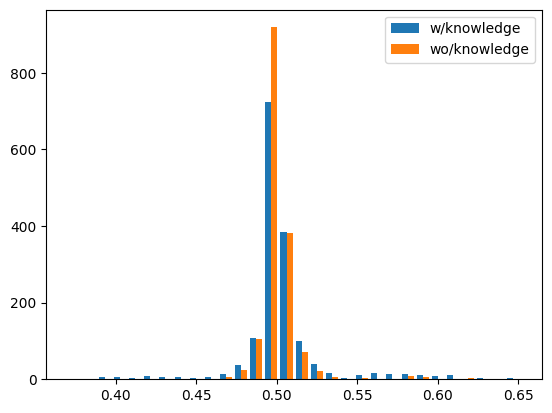

In [90]:
fig, ax = plt.subplots()
ax.hist([probs_know["correct_prob"], probs_no_know["correct_prob"]], bins=30)
ax.legend(["w/knowledge", "wo/knowledge"])
plt.show()

In [91]:
probs_know["correct_prob"].mean(), probs_know["correct_prob"].std()

(0.5034754251045152, 0.026935138549646482)

In [92]:
probs_no_know["correct_prob"].mean(), probs_no_know["correct_prob"].std()

(0.5007899779752892, 0.015181218894677476)

In [93]:
t_stat, p_val = stats.ttest_rel(probs_know["correct_prob"], probs_no_know["correct_prob"])
print("t stat", t_stat, "p value", p_val)

t stat 3.9247544536772514 p value 9.057083212215251e-05


## 6. Prediction Confidence

In [97]:
# calculate gini for each probability distribution and average
probs_no_know["Gini"] = probs_no_know.apply(lambda row: 1 - np.sum(np.array([row["correct_prob"], row["incorrect_prob"]])**2), axis=1)
nk_mean_gini = probs_no_know["Gini"].mean()

# calculate entropy for each probability distribution and average
probs_no_know['Entropy'] = probs_no_know.apply(lambda row: entropy([row['correct_prob'], row['incorrect_prob']], base=2), axis=1)
nk_mean_entropy = probs_no_know["Entropy"].mean()

In [98]:
print("Mean Gini", nk_mean_gini)
print("Mean Entropy", nk_mean_entropy)

Mean Gini 0.4995381051837636
Mean Entropy 0.9993302103409109


In [99]:
# calculate gini for each probability distribution and average
probs_know["Gini"] = probs_know.apply(lambda row: 1 - np.sum(np.array([row["correct_prob"], row["incorrect_prob"]])**2), axis=1)
k_mean_gini = probs_know["Gini"].mean()

# calculate entropy for each probability distribution and average
probs_know['Entropy'] = probs_know.apply(lambda row: entropy([row['correct_prob'], row['incorrect_prob']], base=2), axis=1)
k_mean_entropy = probs_know["Entropy"].mean()

In [100]:
print("Mean Gini", k_mean_gini)
print("Mean Entropy", k_mean_entropy)

Mean Gini 0.49852576418791
Mean Entropy 0.9978605729079391


In [77]:
probs_know["Entropy"].describe()

count    1571.000000
mean        0.997861
std         0.007043
min         0.932360
25%         0.999599
50%         0.999949
75%         0.999993
max         1.000000
Name: Entropy, dtype: float64

In [78]:
probs_no_know["Entropy"].describe()

count    1571.000000
mean        0.999330
std         0.003783
min         0.950530
25%         0.999876
50%         0.999979
75%         0.999997
max         1.000000
Name: Entropy, dtype: float64

## 7. Analyzing attention

In [18]:
# obtain the number of correct predictions in each experiment
probs_know["is_correct"] = probs_know["correct_prob"] > probs_know["incorrect_prob"]
probs_no_know["is_correct"] = probs_no_know["correct_prob"] > probs_no_know["incorrect_prob"]

In [19]:
# obtain the corrected predictions after adding the knowledge
corrected_df = probs_know[(probs_know["is_correct"]) & (~probs_no_know["is_correct"])].copy()
print(f"Number of corrected samples", len(corrected_df), f"{len(corrected_df)/probs_know.shape[0]*100:0.2f}%")

# obtain the incorrect predictions after adding the knowledge
worsened_df = probs_know[(~probs_know["is_correct"]) & (probs_no_know["is_correct"])].copy()
print(f"Number of worsened samples", len(worsened_df), f"{len(worsened_df)/probs_know.shape[0]*100:0.2f}%")

Number of corrected samples 291 18.52%
Number of worsened samples 222 14.13%


Analyze samples that improved.

In [20]:
def retrieveByID(ds, id):
  for samp in ds:
    if samp["InputStoryid"]==id:
      return samp
  return None

In [21]:
#1b06e78a-3f2e-4445-a72f-780b27f3f40d

In [22]:
improved_ids = corrected_df["ID"].values
random_selection = np.random.choice(improved_ids)
random_selection = "1b06e78a-3f2e-4445-a72f-780b27f3f40d"
sample_item = retrieveByID(ds_know, random_selection)
sample_item

{'InputStoryid': '1b06e78a-3f2e-4445-a72f-780b27f3f40d',
 'cands': ['Brandon checked the next day and found 50 cents under his pillow.',
  'Brandon bought a bar of chocolate.'],
 'answer': 'Brandon checked the next day and found 50 cents under his pillow.',
 'query': 'Brandon woke up this morning with his tooth missing. All excited he ran into his parents room. Brandon jumped up and down on their bed. He ran back to his room to put his tooth under his pillow.',
 'knowledge': 'Children often believe in the tradition of the tooth fairy, where they place their lost baby teeth under their pillow at night in exchange for a small gift or money.'}

In [23]:
sample_story, sample_answer, sample_cands = sample_item["query"], sample_item["answer"], sample_item["cands"]
sample_knowledge = sample_item["knowledge"] if "knowledge" in sample_item.keys() else None
if sample_knowledge is not None:
  sample_pred, sample_probs = predict_with_bert(sample_story, sample_cands, sample_knowledge)
  sample_pred_unk, sample_probs_unk = predict_with_bert(sample_story, sample_cands, None)
else:
  sample_pred, sample_probs = predict_with_bert(sample_story, sample_cands, sample_knowledge)


if sample_pred==sample_answer:
  print("Model predicted correctly current sample.")
else:
  print("Model predicted incorrectly current sample.")

Model predicted correctly current sample.


In [24]:
# tokenize concatenated inputs

# tokenize inputs for story w/knowledge and correct answer
inputs_know = tokenizer.encode_plus(sample_story + " " + sample_knowledge, sample_answer, max_length=256, truncation=True, return_tensors='pt', add_special_tokens=True).to(model.device)
# tokenize inputs for story wo/knowledge and correct answer
inputs_normal = tokenizer.encode_plus(sample_story, sample_answer, max_length=256, truncation=True, return_tensors='pt', add_special_tokens=True).to(model.device)

# compute output and attention for both types of inputs
with torch.no_grad():

    # knowledge attention
    outputs_know = model(**inputs_know, output_attentions=True)
    attention_know = outputs_know.attentions

    # wo/knowledge attention
    outputs_normal = model(**inputs_normal, output_attentions=True)
    attention_normal = outputs_normal.attentions


Visualize the attention each token gives to all other tokens in the input for a given attention layer.

In [25]:
def visualizeAttention(layer, att_know, att_normal, inputs_know, inputs_normal, figsize=(16,4)):
  # remove batch dimension
  know_att_layer = att_know[layer].squeeze(0)
  norm_att_layer = att_normal[layer].squeeze(0)

  # Convert token IDs back to tokens
  tokens_know = tokenizer.convert_ids_to_tokens(inputs_know['input_ids'][0])
  tokens_norm = tokenizer.convert_ids_to_tokens(inputs_normal['input_ids'][0])

  # Calculate the average attention across all heads in the selected layer
  avg_attention_know = know_att_layer.mean(dim=0)
  avg_attention_norm = norm_att_layer.mean(dim=0)

  # Find the position of the first [SEP] token
  sep_pos_know = tokens_know.index('[SEP]') + 1
  sep_pos_norm = tokens_norm.index('[SEP]') + 1

  # Slice the attention matrix to only include rows for tokens after [SEP]
  # and all columns to see how these tokens attend to the entire input
  attention_sliced_know = avg_attention_know[sep_pos_know:, :]
  attention_sliced_norm = avg_attention_norm[sep_pos_norm:, :]

  # separate plots for attention with and without knowledge
  fig, ax = plt.subplots(figsize=figsize)

  sns.heatmap(attention_sliced_norm.detach().cpu().numpy(), xticklabels=tokens_norm, yticklabels=tokens_norm[sep_pos_norm:], cmap='viridis', ax=ax)
  ax.set_title(f"Without Knowledge {layer} Attention Layer")
  plt.show()

  fig, ax = plt.subplots(figsize=figsize)
  sns.heatmap(attention_sliced_know.detach().cpu().numpy(), xticklabels=tokens_know, yticklabels=tokens_know[sep_pos_know:], cmap='viridis', ax=ax)
  ax.set_title(f"With Knowledge {layer} Attention Layer")
  plt.show()

  return None


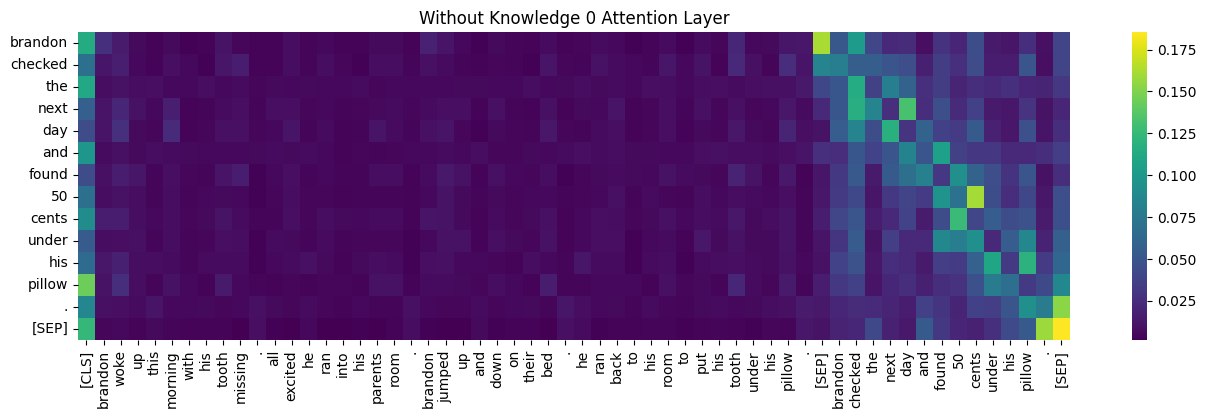

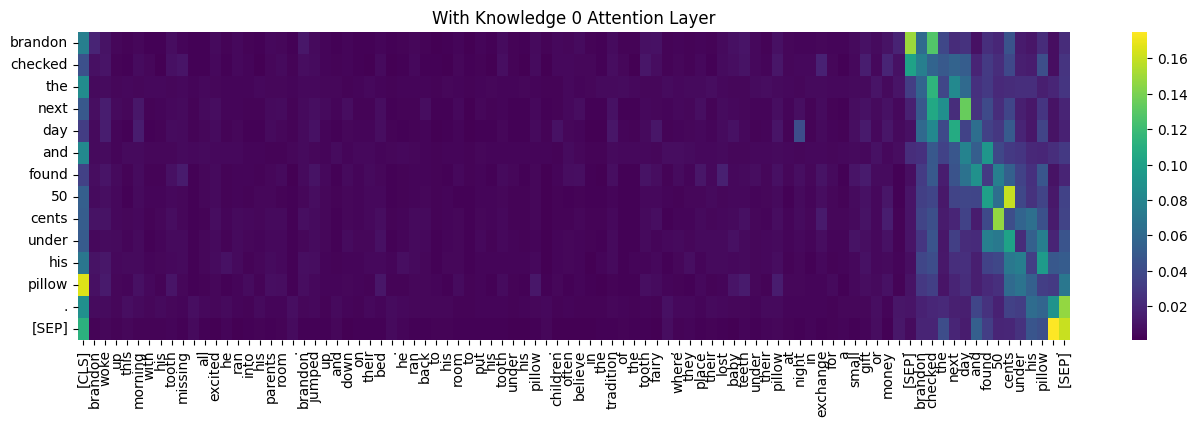

In [26]:
visualizeAttention(0, attention_know, attention_normal, inputs_know, inputs_normal)

Analyze samples that worsened.

In [39]:
worsened_ids = worsened_df["ID"].values
random_selection = np.random.choice(worsened_ids)
sample_item = retrieveByID(ds_know, random_selection)
sample_item

{'InputStoryid': '39d062a5-c89c-462f-a0df-876cba16daf3',
 'cands': ["Pretty soon, Tim's parents hated the sound of the trumpet.",
  'They set up a space in the garage for him to practice.'],
 'answer': 'They set up a space in the garage for him to practice.',
 'query': 'Tim always wanted to play the drums. His parents bought him a set for Christmas. He would play them all the time. It was way too loud and upset his parents.',
 'knowledge': "Playing the drums can be a noisy hobby, as drum sets produce loud sounds that can disturb others in close proximity. It's important to consider noise levels and potentially use noise-reducing tools or practice in designated spaces."}

In [40]:
sample_story, sample_answer, sample_cands = sample_item["query"], sample_item["answer"], sample_item["cands"]
sample_knowledge = sample_item["knowledge"] if "knowledge" in sample_item.keys() else None
if sample_knowledge is not None:
  sample_pred, sample_probs = predict_with_bert(sample_story, sample_cands, sample_knowledge)
  sample_pred_unk, sample_probs_unk = predict_with_bert(sample_story, sample_cands, None)
else:
  sample_pred, sample_probs = predict_with_bert(sample_story, sample_cands, sample_knowledge)


if sample_pred==sample_answer:
  print("Model predicted correctly current sample.")
else:
  print("Model predicted incorrectly current sample.")

Model predicted incorrectly current sample.


In [41]:
# tokenize inputs for story w/knowledge and correct answer
inputs_know = tokenizer.encode_plus(sample_story + " " + sample_knowledge, sample_answer, max_length=256, truncation=True, return_tensors='pt', add_special_tokens=True).to(model.device)
# tokenize inputs for story wo/knowledge and correct answer
inputs_normal = tokenizer.encode_plus(sample_story, sample_answer, max_length=256, truncation=True, return_tensors='pt', add_special_tokens=True).to(model.device)

# compute output and attention for both types of inputs
with torch.no_grad():

    # knowledge attention
    outputs_know = model(**inputs_know, output_attentions=True)
    attention_know = outputs_know.attentions

    # wo/knowledge attention
    outputs_normal = model(**inputs_normal, output_attentions=True)
    attention_normal = outputs_normal.attentions

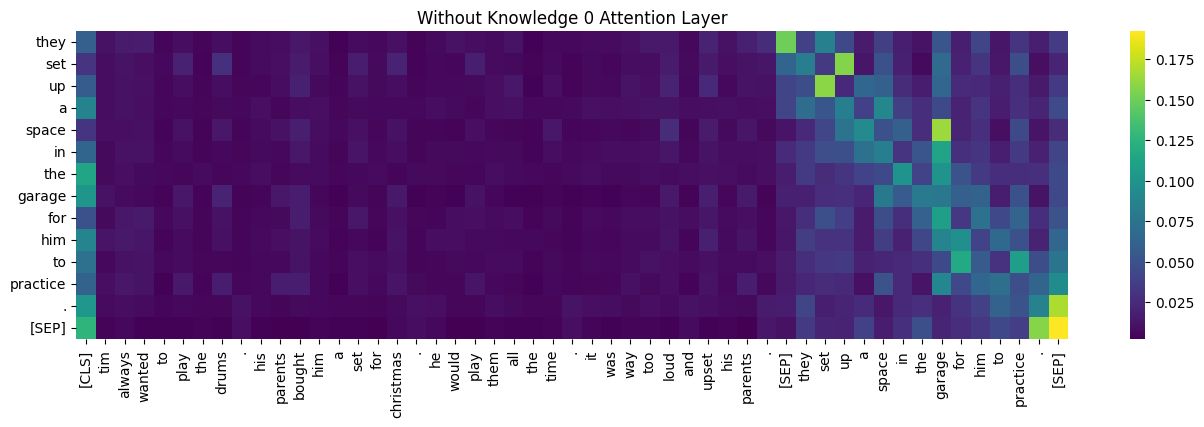

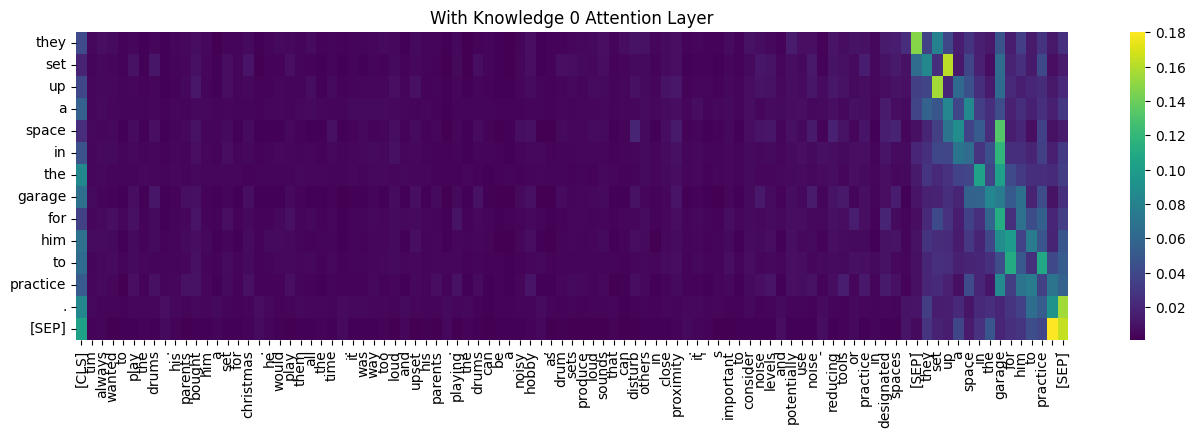

In [42]:
visualizeAttention(0, attention_know, attention_normal, inputs_know, inputs_normal)

In [30]:
def calculateAttendance(attention_lyr, inputs):
  '''
  Given an attention layer, and for each token, find the attentions weights (attention heads are averaged).
  Args:
    attention_lyr
  Returns:
    top_df (pandas DataFrame): top results ordered descendingly
  '''
  top_df = pd.DataFrame(columns=["token", "word", "attention"])

  # Averaging across attention heads
  attention_avg = attention_lyr.mean(dim=1).squeeze(0)  # Remove batch dimension for simplicity

  top_tokens = []
  top_weights = []

  for i in range(attention_avg.size(0)):  # Iterate over all tokens in the sequence
      # Sort attention weights for token i and get indices of top 5
      top_idx = attention_avg[i].topk(5).indices
      top_tokens_i = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][top_idx].tolist())
      top_weights_i = attention_avg[i].topk(5).values.tolist()

      top_tokens.append(top_tokens_i)
      top_weights.append(top_weights_i)

  # Print or process the top tokens and their weights as needed
  for i, (tokens, weights) in enumerate(zip(top_tokens, top_weights)):
    current_token = tokenizer.convert_ids_to_tokens([inputs['input_ids'][0][i].item()])[0]
    #print(f"Token: {current_token}")
    for token, weight in zip(tokens, weights):
      #print(f"  Attends to: {token}, Weight: {weight:.4f}")
      top_df.loc[len(top_df)] = [current_token, token, weight]

  all_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
  ending_tokens = all_tokens[all_tokens.index("[SEP]")+1:-1]

  # retrieve only tokens from the end.
  end_df = top_df[top_df["token"].isin(ending_tokens)].copy()




  return end_df


In [32]:
token_atts = calculateAttendance(attention_know[0], inputs_know)

In [33]:
token_atts.columns

Index(['token', 'word', 'attention'], dtype='object')

In [34]:
token_atts["token"].unique()

array(['brandon', 'his', '.', 'and', 'under', 'pillow', 'the', 'checked',
       'next', 'day', 'found', '50', 'cents'], dtype=object)